<a href="https://colab.research.google.com/github/ravilon/ufpel-pdi/blob/main/LAB6_Remocao_Ruido_Melhoria_Qualidade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LAB6 — Pipeline de Processamento para Remoção de Ruído e Melhoria de Qualidade Visual

Disciplina: **Processamento Digital de Imagens (PDI)** – UFPel  
Professor: **Guilherme Corrêa**  

Vamos exercitar os conceitos estudados até o momento criando um pipeline de processamento de imagens.

Um pipeline de PDI é um fluxo com diversas operações executadas sequencialmente. No caso deste laboratório, vamos executar diversas operações para tentar melhorar a qualidade de uma imagem que tem baixa resolução, sofreu efeito de ruído periódico e também sofreu efeito de ruído sal & pimenta.

Use a imagem `tuyuka_lq.png` está disponível no repositório para os exercícios.

---

## Objetivos  

1. Aplicar conceitos estudados até este momento para melhorar a qualidade de uma imagem que tem baixa resolução, sofreu efeito de ruído periódico e também sofreu efeito de ruído sal & pimenta.
2. Você deve escolher quais passos de PDI aplicar e em qual ordem, considerando tudo o que estudamos até aqui (interpolação, realce, suavização, filtragem no domínio espacial, filtragem no domínio de transformadas...
3. **IMPORTANTE: a ordem de aplicação das técnicas vai influenciar muito no resultado final! Escolha sabiamente!**

---

## Bibliotecas úteis
Se estiver no Colab, rode a célula de instalação uma única vez.

In [35]:
# Se necessário no Colab, descomente a linha abaixo:
#!pip -q install numpy matplotlib scikit-image imageio

In [ ]:
# (execute uma vez)
!pip -q install ipywidgets==8.1.2 scikit-image==0.24.0 opencv-python-headless==4.10.0.84
from google.colab import output
output.enable_custom_widget_manager()

import numpy as np
import matplotlib.pyplot as plt
import cv2
from ipywidgets import interact, IntSlider
from skimage import filters, img_as_float
from skimage import io, color, img_as_ubyte
from google.colab import files



## Upload de uma imagem
Usando `files` do `google.colab` para fazer upload de uma imagem.

In [ ]:

print("Faça upload de uma imagem (JPG/PNG).")
up = files.upload()
if not up:
    raise RuntimeError("Nenhum arquivo enviado.")

# Nome do arquivo
fname = next(iter(up))

# Ler imagem colorida (BGR)
img_bgr = cv2.imdecode(np.frombuffer(up[fname], np.uint8), cv2.IMREAD_COLOR)
if img_bgr is None:
    raise RuntimeError("Falha ao ler a imagem.")

# Converter para escala de cinza (uint8, faixa 0–255)
img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
img_orig = img_gray.astype(np.uint8)

# Mostrar
plt.imshow(img_orig, cmap='gray', vmin=0, vmax=255)
plt.axis('off')
plt.title('Imagem (grayscale, 0–255)')
plt.show()

print("Dimensão:", img_orig.shape, " | dtype:", img_orig.dtype, " | Faixa:", (img_orig.min(), img_orig.max()))


# 🖼️ Passo 1

...



Shape original: (184, 138)


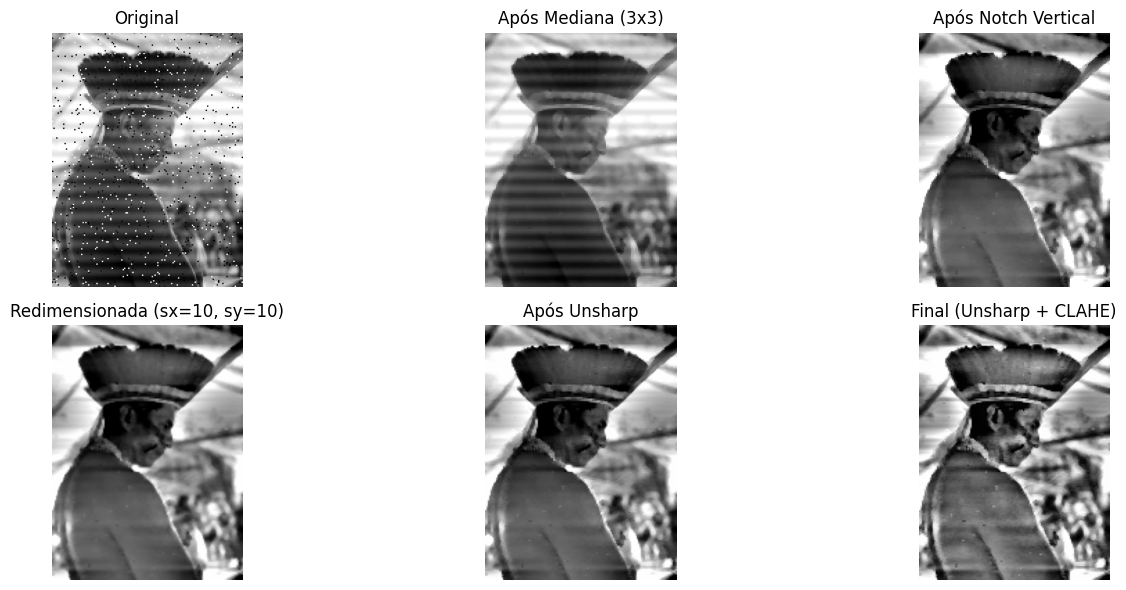

Imagens salvas em /content/:
 - tuyuka_mediana.png
 - tuyuka_notch.png
 - tuyuka_resized.png
 - tuyuka_final.png


In [33]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------------------------------
# Resize bilinear (o mesmo que você já vinha usando)
# ----------------------------------------------------
def resize_bilinear(img, sx, sy):
    img = img.astype(np.float32)
    h_in, w_in = img.shape
    h_out = int(round(h_in * sy))
    w_out = int(round(w_in * sx))

    ys = np.arange(h_out)
    xs = np.arange(w_out)
    y_src = (ys + 0.5) / sy - 0.5
    x_src = (xs + 0.5) / sx - 0.5

    y0 = np.floor(y_src).astype(int)
    x0 = np.floor(x_src).astype(int)
    y1 = np.clip(y0 + 1, 0, h_in - 1)
    x1 = np.clip(x0 + 1, 0, w_in - 1)

    wy = (y_src - y0).reshape(-1, 1)
    wx = (x_src - x0).reshape(1, -1)

    y0 = np.clip(y0, 0, h_in - 1)
    x0 = np.clip(x0, 0, w_in - 1)

    I00 = img[y0[:, None], x0[None, :]]
    I01 = img[y0[:, None], x1[None, :]]
    I10 = img[y1[:, None], x0[None, :]]
    I11 = img[y1[:, None], x1[None, :]]

    out = (1 - wy) * (1 - wx) * I00 + (1 - wy) * wx * I01 \
          + wy * (1 - wx) * I10 + wy * wx * I11

    return np.clip(out, 0, 255).astype(np.uint8)

# ----------------------------------------------------
# Mediana para sal & pimenta
# ----------------------------------------------------
def median_spatial(img, ksize=3):
    return cv2.medianBlur(img, ksize)

# ----------------------------------------------------
# Notch vertical simples (remove listras horizontais)
# ----------------------------------------------------
def notch_vertical(img, width=2):
    """
    width = meia-largura da faixa vertical removida no espectro.
    """
    img_f = img.astype(np.float32)

    F = np.fft.fft2(img_f)
    F_shift = np.fft.fftshift(F)

    M, N = img.shape
    mask = np.ones((M, N), dtype=float)
    center = N // 2
    mask[:, center - width:center + width] = 0.0  # faixa vertical

    G_shift = F_shift * mask
    G = np.fft.ifftshift(G_shift)
    out = np.real(np.fft.ifft2(G))

    # Preserve original mean and standard deviation, then clip
    mean_orig = img_f.mean()
    std_orig = img_f.std()

    mean_out = out.mean()
    std_out = out.std()

    if std_out > 1e-6: # Avoid division by zero
        out = (out - mean_out) * (std_orig / std_out) + mean_orig

    out_u8 = np.clip(out, 0, 255).astype(np.uint8)

    return out_u8, mask

# ----------------------------------------------------
# Unsharp mask (realce de nitidez)
# ----------------------------------------------------
def unsharp(img, sigma=1.0, k=0.8):
    img_f = img.astype(np.float32)
    blur = cv2.GaussianBlur(img_f, (0, 0), sigmaX=sigma)
    mask = img_f - blur
    sharp = img_f + k * mask
    sharp = np.clip(sharp, 0, 255).astype(np.uint8)
    return sharp

# ----------------------------------------------------
# CLAHE (contraste local)
# ----------------------------------------------------
def apply_clahe(img, clip=2.0, tile=(8, 8)):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    return clahe.apply(img)

# ----------------------------------------------------
# PIPELINE COMPLETO
# ----------------------------------------------------
# Ajusta este caminho conforme o teu ambiente
input_path = "/content/tuyuka_lq.png"   # ou "/mnt/data/tuyuka_lq.png"

# 0) Lê imagem original em escala de cinza
img0 = cv2.imread(input_path, 0)
print("Shape original:", img0.shape)

# 1) Mediana (remove sal & pimenta)
img1 = median_spatial(img0, ksize=3)

# 2) Notch vertical (remove listras horizontais)
img2, notch_mask = notch_vertical(img1, width=1)

# 3) Redimensionar (por exemplo, 5x)
sx, sy = 10, 10
img3 = resize_bilinear(img2, sx, sy)

# 4) Unsharp (realce de nitidez)
img4 = unsharp(img3, sigma=3, k=2)

# 5) CLAHE (melhora contraste local)
img5 = apply_clahe(img4, clip=2.0, tile=(10, 10))

# ----------------------------------------------------
# Visualizações para o relatório
# ----------------------------------------------------
plt.figure(figsize=(15, 6))

plt.subplot(2, 3, 1)
plt.imshow(img0, cmap='gray', vmin=0, vmax=255)
plt.title("Original")
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(img1, cmap='gray', vmin=0, vmax=255)
plt.title("Após Mediana (3x3)")
plt.axis('off')

plt.subplot(2, 3, 3)
plt.imshow(img2, cmap='gray', vmin=0, vmax=255)
plt.title("Após Notch Vertical")
plt.axis('off')

plt.subplot(2, 3, 4)
plt.imshow(img3, cmap='gray', vmin=0, vmax=255)
plt.title(f"Redimensionada (sx={sx}, sy={sy})")
plt.axis('off')

plt.subplot(2, 3, 5)
plt.imshow(img4, cmap='gray', vmin=0, vmax=255)
plt.title("Após Unsharp")
plt.axis('off')

plt.subplot(2, 3, 6)
plt.imshow(img5, cmap='gray', vmin=0, vmax=255)
plt.title("Final (Unsharp + CLAHE)")
plt.axis('off')

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# Salvar imagens importantes (para o LAB)
# ----------------------------------------------------
cv2.imwrite("/content/tuyuka_mediana.png", img1)
cv2.imwrite("/content/tuyuka_notch.png", img2)
cv2.imwrite("/content/tuyuka_resized.png", img3)
cv2.imwrite("/content/tuyuka_final.png", img5)

print("Imagens salvas em /content/:")
print(" - tuyuka_mediana.png")
print(" - tuyuka_notch.png")
print(" - tuyuka_resized.png")
print(" - tuyuka_final.png")

# 🖼️ Passo 2
...

In [34]:
...

Ellipsis